In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import glob
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [31]:
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_JITTER_WIDTH = int(0.1171875 * IMG_WIDTH) + IMG_WIDTH
IMG_JITTER_HEIGHT = int(0.1171875 * IMG_HEIGHT) + IMG_HEIGHT
EPOCHS = 10
LAMBDA = 10

In [4]:
def update_progress(max_epoch, epoch, progress, episode):
    bar_length = 50
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Episode {0}, Progress: [{1}] {2:.1f}%, Epoch {3}/{4}".format(episode, "=" * block + "." * (bar_length - block), progress * 100, epoch, max_epoch)
    print(text)

In [5]:
def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image

In [6]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [7]:
def random_jitter(image):
    image = tf.image.resize(image, [IMG_JITTER_WIDTH, IMG_JITTER_HEIGHT], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = random_crop(image)
    image = tf.image.random_flip_left_right(image)
    return image

In [8]:
def preprocess_image_train(image):
    try:
        image = np.atleast_3d(image)
        image = random_jitter(image)
        image = normalize(image)
        return np.asarray(image, dtype='float32')
    except:
        return []

In [9]:
def preprocess_image_test(image):
    try:
        image = normalize(image)
        return np.asarray(image, dtype='float32')
    except:
        return []

In [10]:
train_A = ()
for name in glob.glob('./ukiyoe2photo/trainA/*'):
    train_A += (imread(name),)

In [11]:
train_B = ()
for name in glob.glob('./ukiyoe2photo/trainB/*'):
    train_B += (imread(name),)

In [12]:
test_A = ()
for name in glob.glob('./ukiyoe2photo/testA/*'):
    test_A += (imread(name),)

In [13]:
test_B = ()
for name in glob.glob('./ukiyoe2photo/testB/*'):
    test_B += (imread(name),)

In [14]:
train_A_2 = np.empty((0, 256, 256, 3), float)
length = len(train_A)
for x in range(200):
    try:
        train_A_2 = np.vstack((train_A_2, np.asarray([preprocess_image_train(train_A[x])], dtype='float32')))
    except:
        print(x)
    update_progress(1, 1, x/length, x)
update_progress(1, 1, 1, x)
train_A = train_A_2

Episode 199, Progress: [==================================================] 100.0%, Epoch 1/1


In [15]:
train_B_2 = np.empty((0, 256, 256, 3), float)
length = len(train_B)
for x in range(200):
    try:
        train_B_2 = np.vstack((train_B_2, np.asarray([preprocess_image_train(train_B[x])], dtype='float32')))
    except:
        print(x)
    update_progress(1, 1, x/length, x)
update_progress(1, 1, 1, x)
train_B = train_B_2

Episode 199, Progress: [==================================================] 100.0%, Epoch 1/1


In [16]:
test_A_2 = np.empty((0, 256, 256, 3), float)
length = len(test_A)
for x in range(200):
    try:
        test_A_2 = np.vstack((test_A_2, np.asarray([preprocess_image_train(test_A[x])], dtype='float32')))
    except:
        print(x)
    update_progress(1, 1, x/length, x)
update_progress(1, 1, 1, x)
test_A = test_A_2

Episode 199, Progress: [==================================================] 100.0%, Epoch 1/1


In [17]:
test_B_2 = np.empty((0, 256, 256, 3), float)
length = len(test_B)
for x in range(200):
    try:
        test_B_2 = np.vstack((test_B_2, np.asarray([preprocess_image_train(test_B[x])], dtype='float32')))
    except:
        print(x)
    update_progress(1, 1, x/length, x)
update_progress(1, 1, 1, x)
test_B = test_B_2

Episode 199, Progress: [==================================================] 100.0%, Epoch 1/1


In [18]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [19]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(a, generated):
    a_loss = loss_obj(tf.ones_like(a), a)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = a_loss + generated_loss
    return total_disc_loss * 0.5

In [21]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [22]:
def calc_cycle_loss(a_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(a_image - cycled_image))
    return LAMBDA * loss1

In [23]:
def identity_loss(a_image, same_image):
    loss = tf.reduce_mean(tf.abs(a_image - same_image))
    return LAMBDA * 0.5 * loss

In [24]:
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [25]:
@tf.function
def train_step(a_x, a_y):
    with tf.GradientTape(persistent=True) as tape:
    
        fake_y = generator_g(a_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(a_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(a_x, training=True)
        same_y = generator_g(a_y, training=True)

        disc_a_x = discriminator_x(a_x, training=True)
        disc_a_y = discriminator_y(a_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(a_x, cycled_x) + calc_cycle_loss(a_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(a_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(a_x, same_x)

        disc_x_loss = discriminator_loss(disc_a_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_a_y, disc_fake_y)
  
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [26]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [27]:
checkpoint_path = "checkpoints/train_ukiyoe"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [28]:
MAX = len(list(zip(train_B, train_A)))

In [36]:
for epoch in range(EPOCHS):
    start = time.time()
    n = 0
    for image_x, image_y in zip(train_B, train_A):
        train_step(np.asarray([image_x], dtype='float32'), np.asarray([image_y], dtype='float32'))
        update_progress(EPOCHS, epoch+1, n / MAX, n)
        n+=1
    clear_output(wait=True) 
    generate_images(generator_g, np.asarray([train_B[0]], dtype='float32'))
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

Episode 95, Progress: [========================..........................] 47.5%, Epoch 4/10


KeyboardInterrupt: 

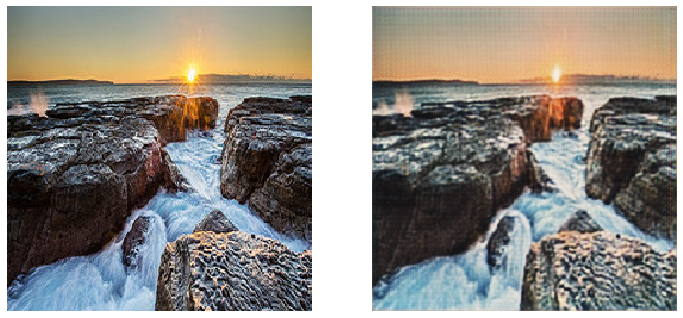

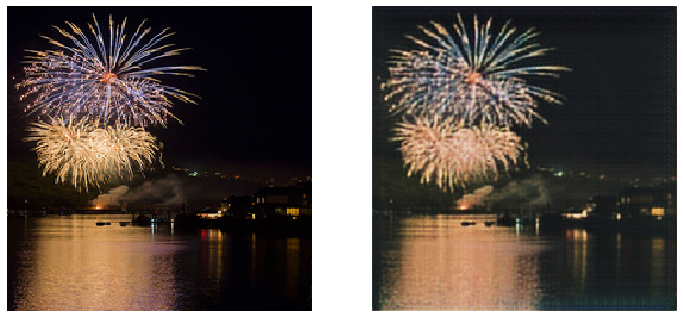

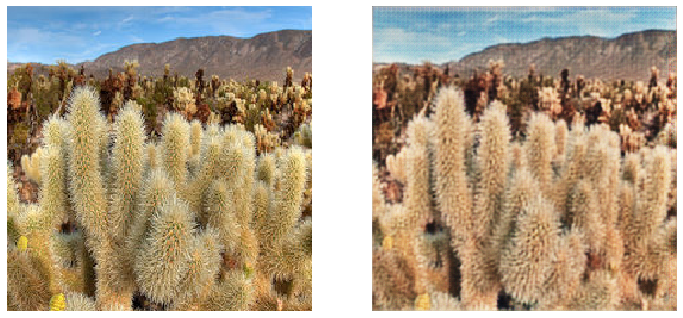

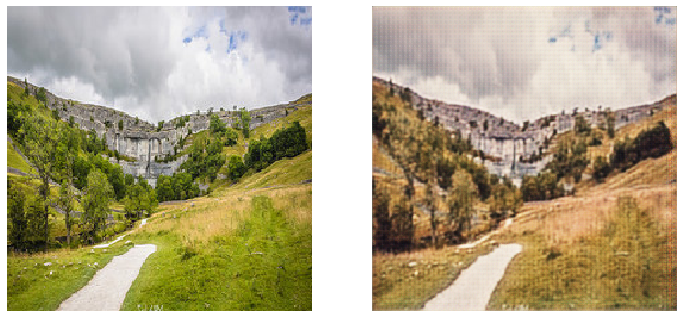

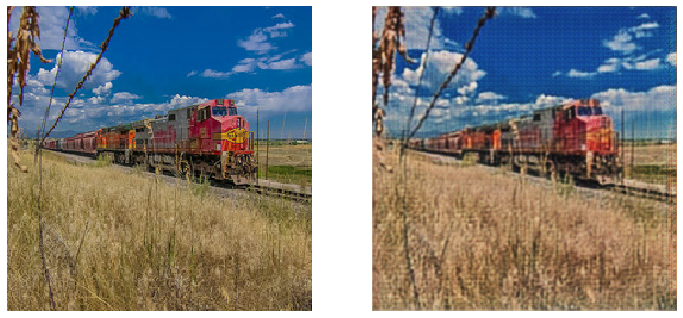

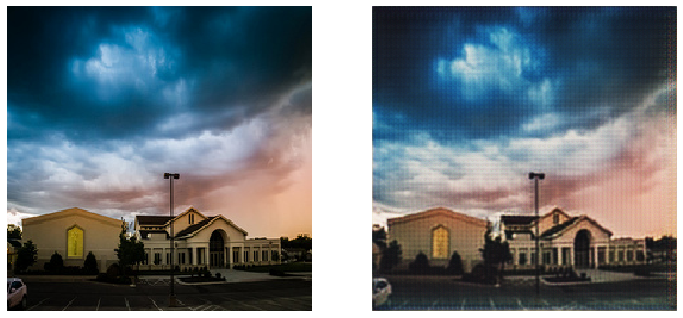

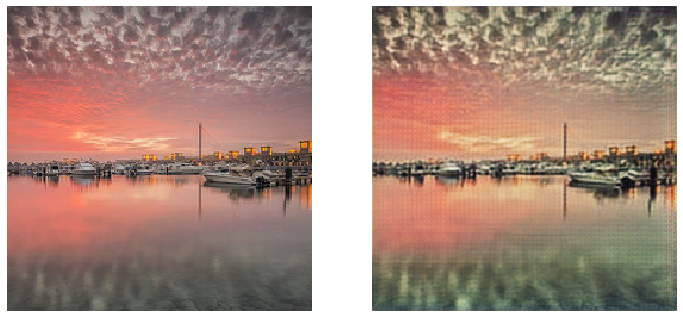

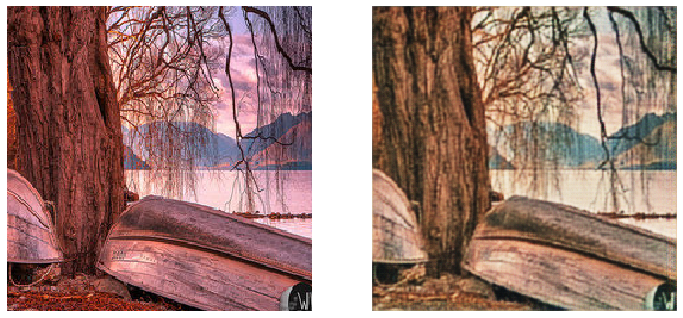

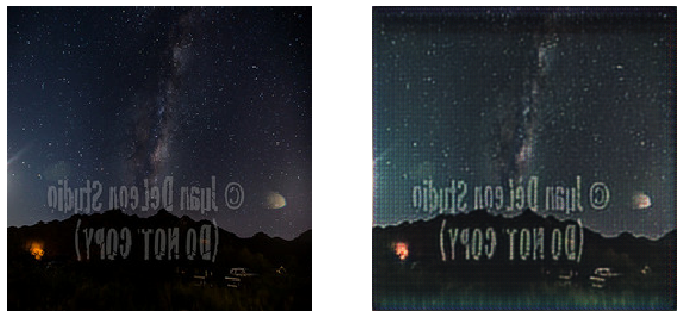

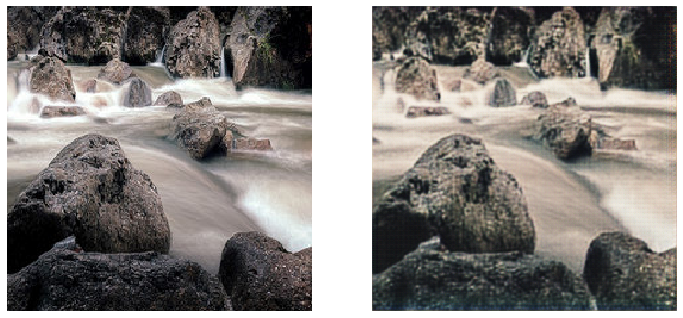

In [37]:
for _ in range(10):
    x = np.random.randint(len(test_B))
    generate_images(generator_g, np.asarray([test_B[x]], dtype='float32'))